In [25]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [26]:
# load dataset
wrld_df = pd.read_csv('world-happiness-report.csv')
wrld_df.shape

(1949, 11)

In [27]:
# display first five rows of dataframe
wrld_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [28]:
# check missing values
wrld_df.isna().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
Positive affect                      22
Negative affect                      16
dtype: int64

In [29]:
# filling missing values with mean
cols_to_impute = ["Log GDP per capita","Social support","Healthy life expectancy at birth","Freedom to make life choices", "Generosity","Perceptions of corruption", "Positive affect", "Negative affect"]

imputer = SimpleImputer(strategy='mean')
for col in cols_to_impute:
    wrld_df[col] = imputer.fit_transform(wrld_df[[col]])

wrld_df.isna().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

*We drop the year column since it's not relevant to the clustering analysis which is focused on the countries' happiness-related metrics*

In [30]:
# dropping year column.
wrld_df = wrld_df.drop('year', axis=1)

*Since we have multiple entries for each country over some years, we aggregate the data using the mean to obtain single record per country*

In [31]:
# aggregating using the mean...
agg_wrld_df = wrld_df.groupby('Country name').mean().reset_index()

In [32]:
# label ecoding for country names
countries = agg_wrld_df['Country name']
encoder = LabelEncoder()
countries_encoded = encoder.fit_transform(countries)

# reshape countries_encoeded
countries_encoded = countries_encoded.reshape(-1,1)

In [33]:
# features to use for clustering
features = agg_wrld_df.columns.difference(['country_encoded', 'Country name'])  #select the dataset except country_encoded and country name

# scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_wrld_df[features])

In [34]:
# concatenate scaled features and countries_encoded
features_scaled_with_countries = np.concatenate((features_scaled, countries_encoded), axis = 1)

### Elbow Method for Silhouette Score (KMeans)

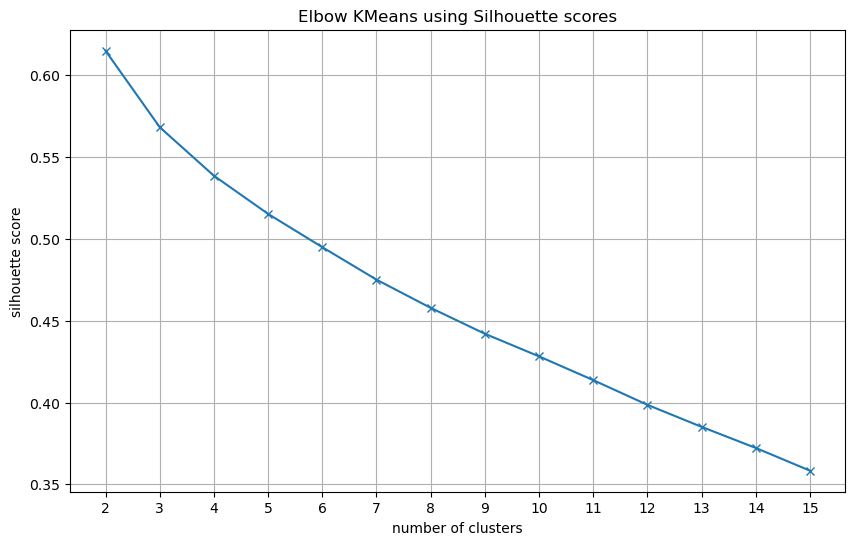

In [35]:
# silhouette score calculation
silhouette_scores = []
cluster_range = range(2, 16)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(features_scaled_with_countries)
    silhouette_scores.append(silhouette_score(features_scaled_with_countries, kmeans_labels))

# plotting the scores
plt.figure(figsize=(10,6))
plt.plot(cluster_range, silhouette_scores, marker='x')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.xticks(np.arange(2, 16, step=1))
plt.title("Elbow KMeans using Silhouette scores")
plt.grid(True)
plt.show()

In [36]:
# determine the optimal clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal numer of clusters: ", optimal_clusters)

Optimal numer of clusters:  2


In [37]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(features_scaled_with_countries)

# Create a DataFrame for the PCA data
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
0,82.516355,3.920009
1,81.506127,0.623194
2,80.503495,0.311045
3,79.512026,2.542149
4,78.496032,-1.692729
...,...,...
161,-78.500926,-0.484096
162,-79.502014,-0.007187
163,-80.489025,3.084582
164,-81.495120,1.966870


### KMeans Clustering (with optimal clusters)

In [38]:
# KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(features_scaled_with_countries)

# Silhouette score for KMeans
kmeans_score = silhouette_score(features_scaled_with_countries, kmeans_labels)
print("KMeans Silhouette score:", kmeans_score)

KMeans Silhouette score: 0.614988237163056


In [39]:
# KMeans with PCA

# KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(pca_data)

# Silhouette score for KMeans
kmeans_score = silhouette_score(pca_data, kmeans_labels)
print("PCA KMeans Silhouette score:", kmeans_score)

PCA KMeans Silhouette score: 0.6184559036608107


### Analysis Section

In [40]:
# add cluster labels to aggregated data
agg_wrld_df['cluster'] = kmeans_labels

*We want to determine which of the clusters is happier by finding the total positive affect scores in each cluster*

In [43]:
# Calculate total Positive affect per cluster for KMeans clustering
positive_affect_per_cluster = agg_wrld_df.groupby('cluster')['Positive affect'].sum()

# Determine the happiest KMeans cluster
happiest_kmeans_cluster = positive_affect_per_cluster.idxmax()
happiest_kmeans_value = positive_affect_per_cluster.max()

print(f'The happiest KMeans cluster is Cluster {happiest_kmeans_cluster + 1} with total Positive affect: {happiest_kmeans_value}')


The happiest KMeans cluster is Cluster 1 with total Positive affect: 59.853773738760516


In [47]:
# Filter countries in the happiest KMeans cluster
happiest_cluster_kmeans = 1  # Assuming cluster 1 is the happiest cluster
countries_in_happiest_kmeans = agg_wrld_df[agg_wrld_df['cluster'] == happiest_cluster_kmeans]['Country name'].tolist()

# display the number of happy countries from analysis
num_of_countries = len(countries_in_happiest_kmeans)
print(f'Number of countries in the happiest cluster (cluster {happiest_cluster_kmeans}): {num_of_countries}')

# Print the countries
print(f'Countries in the happiest KMeans cluster (Cluster {happiest_cluster_kmeans}):')
for country in countries_in_happiest_kmeans:
    print(country)


Number of countries in the happiest cluster (cluster 1): 82
Countries in the happiest KMeans cluster (Cluster 1):
Afghanistan
Albania
Algeria
Angola
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Guatemala
Guinea
Guyana
Haiti
Honduras
Hong Kong S.A.R. of China
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Ivory Coast
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon


Cluster 1 haveing the highest positive affect score means that the factors around them, on average positively affects their happiness.  
although cluster 1 seems to have the highest average postive affect score, it doesnt neceaasirly mean that they are indeed happier that countries in cluster 2

In [ ]:
# check if ghana is any cluster
# check the country with the highest positive affect
# bar plot of top 5 countries in cluster 1
# top 5 countries in cluster 2
# compare the two clusters, which has more countries, plot the bars

# remove the positive affect and negative affect columns and redo to see if any changes happen

In [50]:
# Example: Check if 'Ghana' is in Cluster 1 for KMeans clustering
country_to_check = 'Ghana'
cluster_to_check = 1

# Filter and check if the country is in the specified KMeans cluster
is_in_cluster = agg_wrld_df[(agg_wrld_df['cluster'] == cluster_to_check) & (agg_wrld_df['Country name'] == country_to_check)].shape[0] > 0

if is_in_cluster:
    print(f'{country_to_check} is in Cluster {cluster_to_check} (KMeans)')
else:
    print(f'{country_to_check} is not in Cluster {cluster_to_check} (KMeans)')


Ghana is in Cluster 1 (KMeans)
